In [1]:
# initial setup
try:
    # settings colab:
    import google.colab
        
except ModuleNotFoundError:    
    # settings local:
    %run "common/0_notebooks_base_setup.py"

default checking
Running command `conda list`... ok
jupyterlab=1.2.6 already installed
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
psutil=5.7.0 already installed
scipy=1.4.1 already installed
statsmodels=0.11.0 already installed
scikit-learn=0.22.1 already installed
xlrd=1.2.0 already installed
plotly=4.6.0 already installed
chart-studio=1.1.0 already installed
plotly-orca=1.3.1 already installed
Running command `conda install --yes unicodedata2`... ok
Solving environment: ...working... done

# All requested packages already installed.


Importando librerías ...
Las librerías has sido importadas con éxito


In [2]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

import re
import unicodedata

%matplotlib inline

# Definimos parámetros globales para matplotlib.
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16

In [134]:
def scatter(y_test, y_pred, y):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Medido')
    ax.set_ylabel('Predicho')
    plt.show()

In [3]:
# LECTURA DEL ARCHIVO DE DATOS
data_clean = pd.read_csv("CleanCSV/Clean08_OultiersxZona.csv")
#data_clean =  pd.read_csv('CleanCSV/Clean08_OultiersxZona_Ale_02.csv')

In [4]:
# SÓLO PARA USO EN COMPARACIONES
data_clean_ORIGINAL = data_clean.copy(deep=True) 

In [5]:
data_clean.head(3)

,Unnamed: 0,Unnamed: 0.1,País,Provincia,Área,Localidad,Zona,Lugar,operation,property_type,...,gimnasio,subte,baulera,piscina_house,piscina_depart,desc_banios,tipo_propiedad_PH,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store
0,0,0,Argentina,Capital Federal,Capital Federal,Mataderos,Mataderos,Mataderos,sell,PH,...,0.0,0.0,0.0,0,0,1.0,1,0,0,0
1,1,1,Argentina,Buenos Aires,Zona Sur,La Plata,La Plata,La Plata,sell,apartment,...,0.0,0.0,0.0,0,0,1.0,0,1,0,0
2,2,2,Argentina,Capital Federal,Capital Federal,Mataderos,Mataderos,Mataderos,sell,apartment,...,0.0,0.0,0.0,0,0,1.0,0,1,0,0


In [6]:
display(data_clean.shape)
data_clean.columns

(118570, 44)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'description', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'desc_banios', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store'], dtype='object')

### 0) Primer aproximación al Modelo con lo datos disponibles sólo en Capital

#### Hacemos esto para comparar los R2 que obtendremos más adelante utilizando otros features que harán que el dataset disponible varíe

In [7]:
Xo_yo = data_clean.loc[(data_clean["Área"] == "Capital Federal")].loc[:, ['surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 
                                                                          'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio',
                                                                          'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 
                                                                          'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 
                                                                          'tipo_propiedad_apartment', 'tipo_propiedad_house',
                                                                          'tipo_propiedad_store', "Lugar"]]
Xo_yo.isnull().sum()

surface_total_in_m2         1336
surface_covered_in_m2       2646
price_usd_per_m2            6071
garage                         0
lavadero                       0
balcon                         0
parrilla                       0
jardin                         0
patio                          0
amenities                      0
estrenar                       0
gimnasio                       0
subte                          0
baulera                        0
piscina_house                  0
piscina_depart                 0
tipo_propiedad_PH              0
tipo_propiedad_apartment       0
tipo_propiedad_house           0
tipo_propiedad_store           0
Lugar                          0
dtype: int64

In [8]:
# Eliminamos con nulos
Xo_yo.dropna(how="any", axis=0, inplace= True)
Xo_yo.shape

(23971, 21)

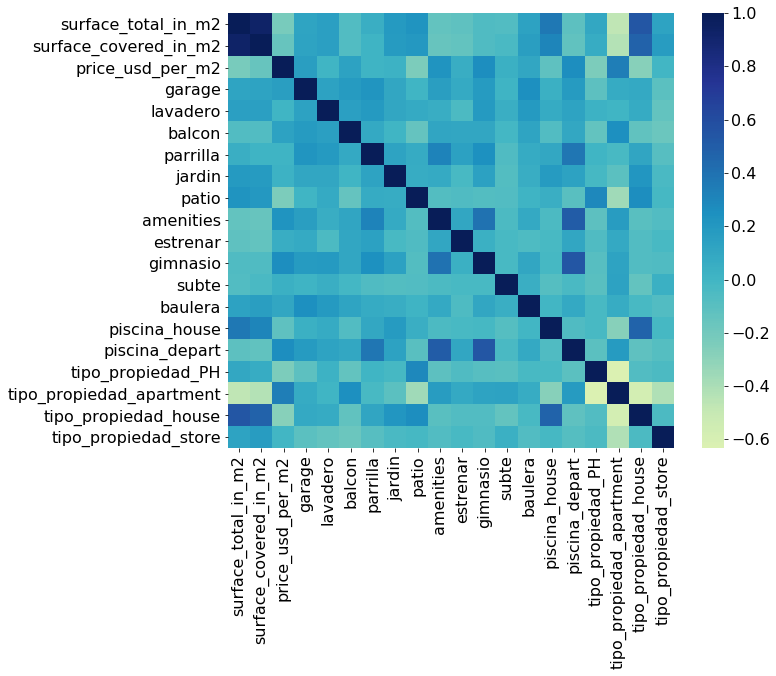

In [153]:
sns.heatmap(Xo_yo.corr(), center=0, cmap="YlGnBu", annot=False);

In [9]:
Xo = Xo_yo[['surface_total_in_m2', 'surface_covered_in_m2',  
            'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio',
            'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 
            'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 
            'tipo_propiedad_apartment', 'tipo_propiedad_house',
            'tipo_propiedad_store', "Lugar"]]
Xo.shape

(23971, 20)

#### 0-a) Armamos las Dummies de "Lugar" (Para el caso de Capital federal, son los barrios/sub-barrios):

In [10]:
dummies_lugar = pd.get_dummies(Xo['Lugar'], prefix="dumm", drop_first=True)  # acá usa drop para generar N-1 columnas
dummies_lugar.shape

(23971, 61)

In [11]:
Xo = pd.concat([Xo, dummies_lugar],axis=1)
Xo.drop(['Lugar'], axis=1, inplace=True)

In [12]:
Xo.columns

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'dumm_Agronomía', 'dumm_Almagro', 'dumm_Balvanera', 'dumm_Barracas', 'dumm_Barrio Norte', 'dumm_Belgrano', 'dumm_Boca', 'dumm_Boedo', 'dumm_Caballito', 'dumm_Capital Federal', 'dumm_Catalinas', 'dumm_Centro / Microcentro', 'dumm_Chacarita', 'dumm_Coghlan', 'dumm_Colegiales', 'dumm_Congreso', 'dumm_Constitución', 'dumm_Flores', 'dumm_Floresta', 'dumm_Las Cañitas', 'dumm_Liniers', 'dumm_Mataderos', 'dumm_Monserrat', 'dumm_Monte Castro', 'dumm_Nuñez', 'dumm_Once', 'dumm_Palermo', 'dumm_Palermo Chico', 'dumm_Palermo Hollywood', 'dumm_Palermo Soho', 'dumm_Palermo Viejo', 'dumm_Parque Avellaneda', 'dumm_Parque Centenario', 'dumm_Parque Chacabuco', 'dumm_Parque Chas', 'dumm_Parque Patricios'

In [13]:
yo = Xo_yo[['price_usd_per_m2']]
yo.shape

(23971, 1)

In [14]:
print("Shape X:", Xo.shape)
print("Type X:", type(Xo))
print("Shape y:", yo.shape)
print("Type y:", type(yo))

Shape X: (23971, 80)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (23971, 1)
Type y: <class 'pandas.core.frame.DataFrame'>


#### 0-b) Usando STATS MODEL - Armamos "Xo_const":

In [15]:
# Importamos "train_test_split" y algunas funciones para calcular la bondad de ajuste.
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [16]:
# USANDO statsmodel tenemos que agregar explícitamente a una constante para que encuentre la Ordenada al Origen:
Xo_const = sm.add_constant(Xo)
Xo_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,garage,lavadero,balcon,parrilla,jardin,patio,amenities,...,dumm_Villa Lugano,dumm_Villa Luro,dumm_Villa Ortuzar,dumm_Villa Pueyrredón,dumm_Villa Real,dumm_Villa Riachuelo,dumm_Villa Santa Rita,dumm_Villa Soldati,dumm_Villa Urquiza,dumm_Villa del Parque
0,1.0,55.0,40.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,55.0,55.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,45.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### 0-c) Usando STATS MODEL - con "Xo_const":

In [17]:
# USANDO TRAIN / TEST / SPLIT
X_train, X_test, y_train, y_test = train_test_split(Xo_const, yo)

In [18]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model      
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 243961.7802630258
EMC train: 250225.5620576985
R2:  0.5760838999232787
R2: train: 0.5760838999232787
R2: TEST: 0.5706809031400948


In [19]:
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     307.9
Date:                Tue, 23 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:40:51   Log-Likelihood:            -1.3702e+05
No. Observations:               17978   AIC:                         2.742e+05
Df Residuals:                   17898   BIC:                         2.748e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

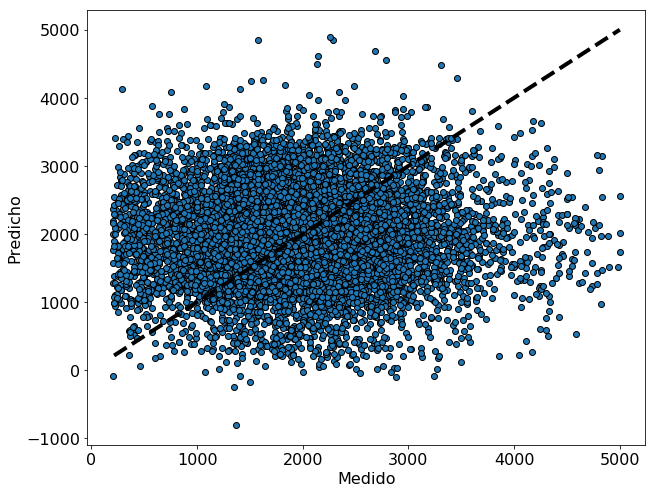

In [135]:
scatter(y_test, predictions2, yo)

##### Se observa que para los Datos de Capital Federal, incluyendo Dummies por Barrio obtenermos, R2 Train/Test de 0,58 / 0,55.


### AHORA VAMOS A VOLVER A TODO EL DATASET DISPONIBLE PARA TODA LA ARGENTINA:

<hr id="Ubicaciones">

### 1) Imputamos valores adicionales en la columna "ROOMS"

In [20]:
print(data_clean.rooms.isnull().sum())

64741


In [21]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("\d\sambientes", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" ambientes", "").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

64741
53585


In [22]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("\d\samb", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" amb", "").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

53585
50429


In [23]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("1\sambiente", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" ambiente", "").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

50429
50429


In [24]:
print(data_clean.rooms.isnull().sum())
regex = re.compile("un\sambiente", flags = re.IGNORECASE)
regexRooms = data_clean[(data_clean.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace("un ambiente", "1").strip()).astype(np.float64)
data_clean.loc[resultado.index, "rooms"]  = resultado
print(data_clean.rooms.isnull().sum())

50429
49892


In [25]:
data_clean = data_clean.drop(columns=["description"])

### 2) BINARIZACIÓN DE LAT-LOT (ARMADO DE PARCELAS)

In [26]:
data_clean.lat.describe()
print(data_clean.lat.isnull().sum())
data_clean.lon.describe()
data_clean.lon.isnull().sum()

50412


50412

In [27]:
# Eliminamos filas sin LAT o LOT
data_clean.dropna(subset=['lat', 'lon'], how="any", axis=0, inplace= True)

In [28]:
data_clean.lat.describe()
print(data_clean.lat.isnull().sum())
data_clean.lon.describe()
data_clean.lon.isnull().sum()

0


0

In [29]:
data_clean.shape

(68158, 43)

In [30]:
# Vemos cómo nos queda distribuídas geográficamente las muestras luego del Drop anterior
data_clean.Área.value_counts()[0:40]

Capital Federal        23204
Zona Norte             11197
Costa Atlántica         8029
Zona Sur                5849
Zona Oeste              5515
Santa Fe                5232
Córdoba                 5044
Interior                1513
Neuquén                  470
Río Negro                432
Misiones                 363
Mendoza                  333
Entre Ríos               258
Salta                    207
Tucumán                  128
San Luis                 126
La Pampa                  64
Chubut                    52
Chaco                     40
San Juan                  23
Jujuy                     22
Tierra Del Fuego          22
Santa Cruz                17
Corrientes                10
La Rioja                   4
Catamarca                  3
Santiago Del Estero        1
Name: Área, dtype: int64

In [31]:
# Con 4000 BINS en LAT se obtienen una resolución de 0.015 grados por BIN (unas 14 cuadras)
lat_bins= pd.cut(data_clean.lat, 4000, right=False)
display(lat_bins)
lat_categories = pd.cut(data_clean.lat, 4000, right=False, labels=False) # labels=False implica que me devuelve el bin al que pertenece
lat_categories

0         [-34.668, -34.653)
1         [-34.905, -34.891)
2         [-34.653, -34.638)
3         [-34.653, -34.638)
4         [-38.007, -37.993)
                 ...        
118503    [-34.609, -34.594)
118508    [-34.594, -34.579)
118510    [-34.564, -34.549)
118559    [-34.564, -34.549)
118567    [-34.579, -34.564)
Name: lat, Length: 68158, dtype: category
Categories (4000, interval[float64]): [[-54.824, -54.809) < [-54.809, -54.794) < [-54.794, -54.779) < [-54.779, -54.765) ... [4.486, 4.501) < [4.501, 4.516) < [4.516, 4.531) < [4.531, 4.605)]

0         1358
1         1342
2         1359
3         1359
4         1133
          ... 
118503    1362
118508    1363
118510    1365
118559    1365
118567    1364
Name: lat, Length: 68158, dtype: int64

In [32]:
lat_categories = lat_categories.astype("str", copy=True)
type(lat_categories[0])

str

In [33]:
# Con 2000 BINS en LON se obtienen una resolución de 0.011 grados por BIN (unas 8 cuadras)
lon_bins= pd.cut(data_clean.lon, 2000, right=False)
display(lon_bins)
lon_categories = pd.cut(data_clean.lon, 2000, right=False, labels=False) # labels=False impluca que me devuelve el bin al que pertenece
lon_categories.value_counts()

0         [-58.517, -58.506)
1         [-57.969, -57.958)
2         [-58.528, -58.517)
3         [-58.517, -58.506)
4         [-57.552, -57.541)
                 ...        
118503    [-58.408, -58.397)
118508    [-58.408, -58.397)
118510    [-58.452, -58.441)
118559    [-58.452, -58.441)
118567    [-58.485, -58.474)
Name: lon, Length: 68158, dtype: category
Categories (2000, interval[float64]): [[-75.679, -75.668) < [-75.668, -75.657) < [-75.657, -75.646) < [-75.646, -75.635) ... [-53.777, -53.766) < [-53.766, -53.755) < [-53.755, -53.744) < [-53.744, -53.711)]

1652    3379
1574    2742
1571    2621
1570    2138
1568    2123
        ... 
726        1
917        1
1492       1
1428       1
0          1
Name: lon, Length: 753, dtype: int64

In [34]:
lon_categories = lon_categories.astype("str", copy=True)
type(lon_categories[0])

str

In [35]:
lat_lon = lat_categories + "/" + lon_categories
lat_lon.value_counts()

1133/1652    2024
1363/1574     769
1132/1652     618
1364/1571     617
1365/1569     605
             ... 
1578/1610       1
1207/1401       1
1571/1361       1
1573/1057       1
1969/1922       1
Length: 3988, dtype: int64

In [36]:
lat_lon.shape

(68158,)

In [37]:
data_clean = pd.concat([data_clean, lat_lon], axis=1)

In [38]:
data_clean.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'desc_banios', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 0], dtype='object')

In [39]:
# Renombramos la columna que recién creamos (por defecto la llamó 0)
data_clean.rename(columns={0: "lat_lon"}, inplace=True)

### 3) Eliminamos algunas columnas que ya no utilizaremos

In [40]:
data_clean.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'desc_banios', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'lat_lon'], dtype='object')

In [41]:
data_clean.drop(['Unnamed: 0', 'Unnamed: 0.1', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 
                 'floor', 'expenses', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 
                 'desc_banios'], axis=1, inplace=True)

In [42]:
data_clean.columns

Index(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'lat_lon'], dtype='object')

### 4) Generamos DUMMIES para los pares de LAT-LON que generamos antes

In [43]:
dummies_lat_lon = pd.get_dummies(data_clean['lat_lon'], drop_first=True)  # acá usa drop para generar N-1 columnas
dummies_lat_lon.shape

(68158, 3987)

In [44]:
data_clean = pd.concat([data_clean, dummies_lat_lon],axis=1)

In [45]:
data_clean.columns

Index(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       ...
       '989/400', '989/401', '990/397', '990/400', '990/404', '990/408', '991/410', '993/398', '994/397', '994/419'], dtype='object', length=4016)

### 4) "dataf" es una dataframe intermedio donde verificamos que ya no tengamos nulos en las columnas de interés

In [46]:
data_clean.isnull().sum()[0:20]

País                         0
Provincia                    0
Área                         0
Localidad                    0
Zona                         0
Lugar                        0
price_aprox_usd          10998
surface_total_in_m2      11165
surface_covered_in_m2    12841
price_usd_per_m2         19058
rooms                    16987
garage                       0
lavadero                     0
balcon                       0
parrilla                     0
jardin                       0
patio                        0
amenities                    0
estrenar                     0
gimnasio                     0
dtype: int64

In [47]:
dataf = data_clean.dropna(how="any", axis=0)

In [48]:
dataf.isnull().sum().sum()

0

In [49]:
dataf.shape

(35739, 4016)

In [50]:
# Vemos nuevamente cómo nos quedan los datos disponibles distribuídos geográficamente
dataf.Área.value_counts()[0:40]

Capital Federal        16317
Zona Norte              5832
Costa Atlántica         4740
Zona Sur                2398
Zona Oeste              2280
Santa Fe                1657
Córdoba                 1531
Interior                 476
Neuquén                  150
Río Negro                128
Misiones                  78
Mendoza                   58
Salta                     19
Tierra Del Fuego          13
Entre Ríos                12
Tucumán                   11
Chaco                     10
Chubut                     8
San Luis                   8
Santa Cruz                 6
Jujuy                      2
Corrientes                 2
La Rioja                   2
Santiago Del Estero        1
Name: Área, dtype: int64

In [51]:
dataf.columns[0:30]

Index(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store', 'lat_lon', '0/669'], dtype='object')

### 5) Armamos X e y

In [52]:
X = dataf.drop(['País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'price_usd_per_m2', 'lat_lon', 'price_aprox_usd'], axis=1)

In [53]:
X.shape

(35739, 4007)

In [54]:
y = dataf['price_usd_per_m2']

In [55]:
y.shape

(35739,)

In [56]:
print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (35739, 4007)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (35739,)
Type y: <class 'pandas.core.series.Series'>


<hr id="Ubicaciones">

### 6) Pimera aproximación con STATS MODEL - OLS

In [57]:
# Importamos "train_test_split" y algunas funciones para calcular la bondad de ajuste.
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [58]:
# USANDO statsmodel tenemos que agregar explícitamente a una constante para que encuentre la Ordenada al Origen:
X_const = sm.add_constant(X)
X_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,rooms,garage,lavadero,balcon,parrilla,jardin,patio,...,989/400,989/401,990/397,990/400,990/404,990/408,991/410,993/398,994/397,994/419
0,1.0,55.0,40.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,55.0,55.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,45.0,40.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### 6-a) Usando "X_const":

In [59]:
# USANDO TRAIN / TEST / SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_const, y)

In [60]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model      
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 175398.7233332928
EMC train: 210807.49167842936
R2:  0.7486390648768699
R2: train: 0.7486390648768699
R2: TEST: 0.6996034727553146


In [61]:
print (model.summary())

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     37.14
Date:                Tue, 23 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:43:06   Log-Likelihood:            -1.9986e+05
No. Observations:               26804   AIC:                         4.037e+05
Df Residuals:                   24813   BIC:                         4.200e+05
Df Model:                        1990                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

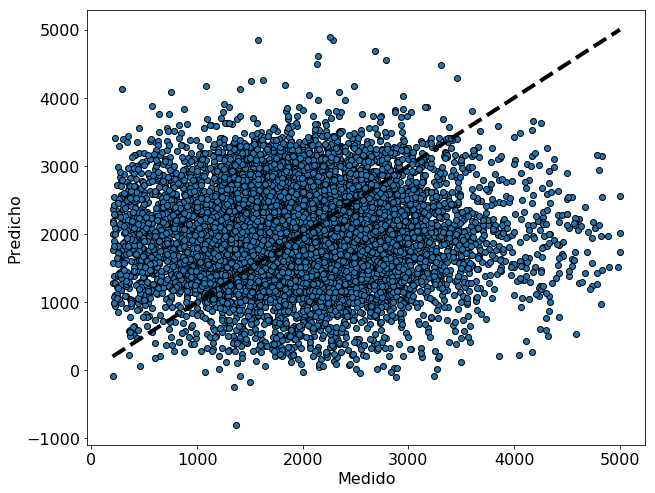

In [136]:
scatter(y_test, predictions2, y)

##### El uso de las parcelas es muy importante para el modelo.
##### Se mostró más arriba que intentamos utilizar dummies de la columna "Lugar" en lugar de las parcelas y no obteníamos R2 mejores a 0,56 / 0,57

### Primer eliminación de features con STATS MODEL - OLS:
##### Se eliminaran Features cuyo Pvalue supere el 1% (es decir que no están afectando a la varianza ni al sesgo del modelo)

In [62]:
not_feature_cols = model.pvalues[model.pvalues>0.01].index.values

In [63]:
not_feature_cols

array(['rooms', 'parrilla', 'jardin', ..., '989/397', '989/399',
       '989/400'], dtype=object)

#### Armamos "X2_const":

In [64]:
X2_const = X_const.drop(not_feature_cols, axis=1)

In [65]:
X2_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,garage,lavadero,balcon,patio,amenities,estrenar,gimnasio,...,989/396,989/401,990/397,990/400,990/404,990/408,991/410,993/398,994/397,994/419
0,1.0,55.0,40.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,55.0,55.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,45.0,40.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Segunda aproximación con STATS MODEL - OLS

#### Usando "X2_const"

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X2_const, y)

In [67]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 197843.9249675552
EMC train: 207961.60109343156
R2:  0.7166421781067809
R2: train: 0.7166421781067808
R2: TEST: 0.7031300786047405


In [68]:
model.summary()

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_usd_per_m2   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     158.9
Date:                Tue, 23 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:43:27   Log-Likelihood:            -2.0147e+05
No. Observations:               26804   AIC:                         4.038e+05
Df Residuals:                   26383   BIC:                         4.072e+05
Df Model:                         420                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1510.5399      7.968    189.583      0.000    1494.923    1526.157
surface_total_in_m2      -3.3676      0.053    -63.830      0.000      -3.471      -3.264
surface_covered_in_m2     1.5837      0.076     20.757      0.000       1.434       1.733
garage                  130.7083      6.131     21.318      0.000     118.691     142.726
lavadero                -28.0695      6.089     -4.610      0.000     -40.004     -16.135
balcon                   67.4747      6.081     11.097      0.000      55.557      79.393
patio                  -239.9041      7.634    -31.424      0.000    -254.868    -224.940
amenities                79.1001     10.885      7.267      0.000      57.765     100.435
estrenar                112.9297      9.591     11.775      0.000      94.131     131.728
gimnasio                208.4738     12.502     16.676      0.000     183.970     232.978
subte                    -5.8327     11.978     -0.487      0.626     -29.311      17.645
baulera                  50.8759      9.024      5.638      0.000      33.189      68.563
piscina_house           114.8087     14.639      7.842      0.000      86.115     143.503
piscina_depart          187.9361      9.908     18.968      0.000     168.516     207.356
tipo_propiedad_store    217.6946     58.938      3.694      0.000     102.173     333.216
1064/740               -561.2484    200.614     -2.798      0.005    -954.463    -168.034
1066/1311              1190.7811    317.247      3.753      0.000     568.960    1812.603
1066/737              -1.465e-10   7.33e-11     -2.000      0.046    -2.9e-10   -2.89e-12
1069/397               3.439e-10    2.7e-10      1.275      0.202   -1.85e-10    8.73e-10
1069/687              -1.793e-10   3.08e-10     -0.583      0.560   -7.82e-10    4.23e-10
1069/690              -2.417e-10   3.49e-10     -0.692      0.489   -9.26e-10    4.43e-10
1069/693                928.5846     67.322     13.793      0.000     796.629    1060.540
1070/683              -9.057e-10   3.18e-10     -2.849      0.004   -1.53e-09   -2.83e-10
1071/699               -2.77e-10   2.73e-10     -1.015      0.310   -8.12e-10    2.58e-10
1071/700              -1028.7574    448.388     -2.294      0.022   -1907.622    -149.893
1084/1219             -3.763e-10   3.98e-10     -0.945      0.345   -1.16e-09    4.04e-10
1085/1228              2.863e-10   3.07e-10      0.934      0.351   -3.15e-10    8.87e-10
1095/1543             -4.102e-10   3.96e-10     -1.036      0.300   -1.19e-09    3.66e-10
1115/1626              -176.4645     91.837     -1.922      0.055    -356.469       3.540
1118/1634             -7.285e-10   1.94e-10     -3.746      0.000   -1.11e-09   -3.47e-10
1119/1639              8.346e-11   3.15e-10      0.265      0.791   -5.34e-10    7.01e-10
1122/1540             -

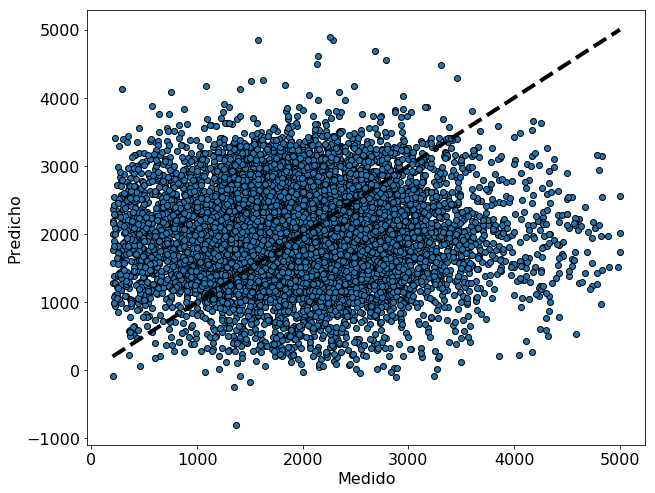

In [137]:
scatter(y_test, predictions2, y)

In [69]:
X2_const.columns

Index(['const', 'surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio',
       ...
       '989/396', '989/401', '990/397', '990/400', '990/404', '990/408', '991/410', '993/398', '994/397', '994/419'], dtype='object', length=1520)

#### Segunda eliminación de features con STATS MODEL - OLS
##### Este paso lo realizamos porque próximamente generaremos nuevas features y si la mantenemos todas ahora, luego las PC no logran alojar en memoria el procesamiento necesario


In [70]:
not_feature_cols = model.pvalues[model.pvalues>0.01].index.values
not_feature_cols

array(['subte', '1066/737', '1069/397', '1069/687', '1069/690',
       '1071/699', '1071/700', '1084/1219', '1085/1228', '1095/1543',
       '1115/1626', '1119/1639', '1122/1540', '1127/1652', '1130/1650',
       '1134/1304', '1134/1647', '1134/1649', '1138/1631', '1139/1648',
       '1174/614', '1178/1511', '1181/1702', '1192/1712', '1194/1716',
       '1219/1731', '1222/1731', '1225/1035', '1226/1036', '1228/1729',
       '1292/1303', '1296/1552', '1297/1609', '1298/1551', '1305/1537',
       '1310/1544', '1311/1678', '1327/1606', '1333/1572', '1339/1576',
       '1340/1524', '1340/1619', '1341/1563', '1342/1578', '1343/1577',
       '1343/1578', '1343/1606', '1344/1601', '1346/1557', '1346/1576',
       '1347/1571', '1348/1533', '1348/1553', '1349/1552', '1349/1563',
       '1349/1588', '1350/1544', '1351/1594', '1352/1565', '1352/1581',
       '1352/1584', '1352/1589', '1356/1574', '1357/1566', '1358/1535',
       '1359/1569', '1360/1542', '1360/673', '1363/1559', '1364/1534',
    

#### Armamos "X3_const":

In [71]:
X3_const = X2_const.drop(not_feature_cols, axis=1)

In [72]:
X3_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,garage,lavadero,balcon,patio,amenities,estrenar,gimnasio,...,988/397,989/396,989/401,990/397,990/400,990/408,991/410,993/398,994/397,994/419
0,1.0,55.0,40.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,55.0,55.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,45.0,40.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Tercera aproximación con STATS MODEL - OLS

#### Usando "X3_const"

In [73]:
# USANDO statsmodel
X_train, X_test, y_train, y_test = train_test_split(X3_const, y)
model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: TEST:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 200422.06113545116
EMC train: 205309.61977928
R2:  0.7143532939748085
R2: train: 0.7143532939748085
R2: TEST: 0.7025346479465273


#### Observamos que el modelo mantiene el R2 de Test y Train luego de haber filtrado parámetros con Pvlues mayores al 1%

In [74]:
model.summary()

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_usd_per_m2   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     205.0
Date:                Tue, 23 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:43:43   Log-Likelihood:            -2.0165e+05
No. Observations:               26804   AIC:                         4.039e+05
Df Residuals:                   26480   BIC:                         4.066e+05
Df Model:                         323                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1506.8215      7.807    193.011      0.000    1491.520    1522.124
surface_total_in_m2      -3.3559      0.053    -63.664      0.000      -3.459      -3.253
surface_covered_in_m2     1.5841      0.076     20.891      0.000       1.435       1.733
garage                  128.2567      6.150     20.855      0.000     116.203     140.311
lavadero                -26.6737      6.113     -4.363      0.000     -38.655     -14.692
balcon                   69.3045      6.113     11.337      0.000      57.322      81.287
patio                  -239.1773      7.644    -31.288      0.000    -254.161    -224.194
amenities                83.3831     10.867      7.673      0.000      62.083     104.683
estrenar                111.3549      9.583     11.620      0.000      92.572     130.137
gimnasio                211.6185     12.480     16.957      0.000     187.157     236.079
baulera                  40.9969      9.072      4.519      0.000      23.216      58.778
piscina_house           118.8635     14.508      8.193      0.000      90.426     147.301
piscina_depart          182.4714      9.945     18.347      0.000     162.978     201.965
tipo_propiedad_store    203.0250     55.146      3.682      0.000      94.936     311.114
1064/740               -346.5126    318.563     -1.088      0.277    -970.914     277.888
1066/1311              1115.6518    260.291      4.286      0.000     605.468    1625.835
1069/693                927.8336     71.683     12.944      0.000     787.332    1068.335
1070/683              -1.839e-11   1.87e-12     -9.835      0.000   -2.21e-11   -1.47e-11
1118/1634             -8.355e-12   1.55e-12     -5.375      0.000   -1.14e-11   -5.31e-12
1126/1626              1.077e-12    1.4e-12      0.771      0.441   -1.66e-12    3.82e-12
1126/1645               616.6452    143.039      4.311      0.000     336.282     897.008
1131/1652               303.3705     83.865      3.617      0.000     138.990     467.751
1131/1653               910.4408     78.595     11.584      0.000     756.391    1064.490
1131/1654              1484.8801    450.644      3.295      0.001     601.593    2368.167
1132/1650               221.6060     54.524      4.064      0.000     114.736     328.477
1132/1651               412.3388     51.599      7.991      0.000     311.202     513.476
1132/1652               432.1681     26.871     16.083      0.000     379.500     484.836
1132/1653               447.2733     35.095     12.745      0.000     378.486     516.060
1132/1654               961.1514     74.339     12.929      0.000     815.444    1106.859
1133/1611             -1.135e-11   1.67e-12     -6.778      0.000   -1.46e-11   -8.07e-12
1133/1651               340.2293     36.202      9.398      0.000     269.271     411.188
1133/1652              

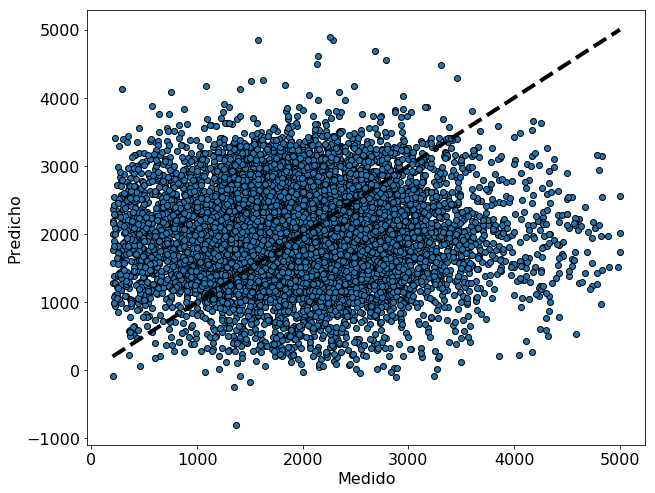

In [138]:
scatter(y_test, predictions2, y)

### 7) Probando diferentes Modelos

#### Armamo "X3" (sólo se requiere eliminar la columna "const")

In [75]:
X3 = X3_const.drop(["const"], axis=1)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X3, y)

#### 7-a) Ridge Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [141]:
# X_train, X_test, y_train, y_test
# SIEMPRE NORMALIZAMOS CUANDO HACEMOS REGULARIZACIÓN (RIGDE, LASSO, ETC..) PORQUE SINO COMO LOS BETAS DE CADA
# FEATURE ESTÁN EN ESCALAS DIFERENTE, PENALIZARÍA MAS A FEATURES EN RANGOS MUY GRANDES,
# ES DECIR, PENALIZARÍA DIFERENTE A CADA FEATURE
# ADEMÁS, AYUDA AL TIEMPO DE PROCESAMIENTO
# OJO QUE LOS BETA QUE OBTENEMOS ESTARÁN TAMBIÉN EN OTRA ESCALA, TAMBIÉN ESTARÁN NORMALIZADOS

rlm = linear_model.Ridge(alpha=0.01, normalize=True)   # EN GENERAL SIEMPRESE SE HACE NORMALIZACIÓN CON RIDGE

# Ajustamos nuevamente, esta vez con regularizacion (RIDGE)
ridge_model = rlm.fit(X_train, y_train)
predictions = ridge_model.predict(X_train)
predictions2 = ridge_model.predict(X_test)
# SUPUESTAMENTE EL MÉTODO PREDICT TOMA LOS X Y LOS NORMALIZA ANTES DE PREDECIR, SI ASÍ LO SETIE EN EL MODELO.
# SINO NO FUNCIONARÍA, O SI YO QUISIERA ARMAR EL MODELO CON LOS BETAS Y CORFICIENTES YO DEBERÍA NORMALIZAR LAS X

print ("r^2 Train:", ridge_model.score(X_train, y_train))
print ("r^2 TEST:", ridge_model.score(X_test, y_test))


r^2 Train: 0.7168774202536436
r^2 TEST: 0.7081548686679935


In [78]:
ridge_model.alpha

0.01

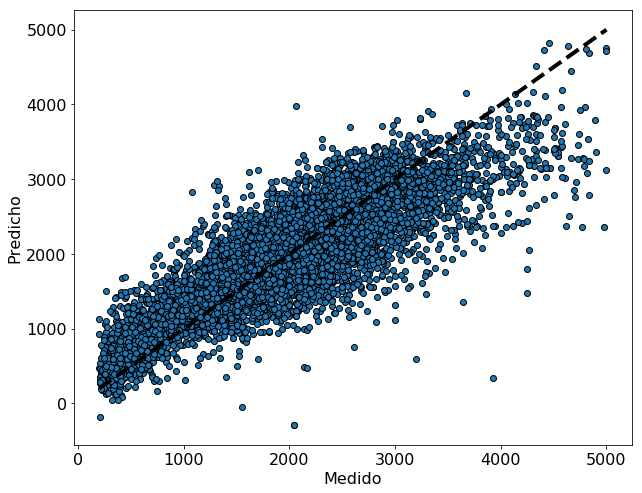

In [142]:
scatter(y_test, predictions2, y)

#### 7-b) Lasso Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [144]:
# X_train, X_test, y_train, y_test

lasso = linear_model.Lasso(alpha=0.01, normalize=True) # SIEMPRE HACER NORMALIZACIÓN CON LASSO

# Ajustamos nuevamente, esta vez con regularizacion (LASSO)
lasso_model = lasso.fit(X_train, y_train)
predictions = lasso_model.predict(X_train)
predictions2 = lasso_model.predict(X_test)

print ("r^2 Train:", lasso_model.score(X_train, y_train))
print ("r^2 TEST:", lasso_model.score(X_test, y_test))


r^2 Train: 0.7156378473137128
r^2 TEST: 0.7075430103224694


In [80]:
lasso_model.alpha

0.01

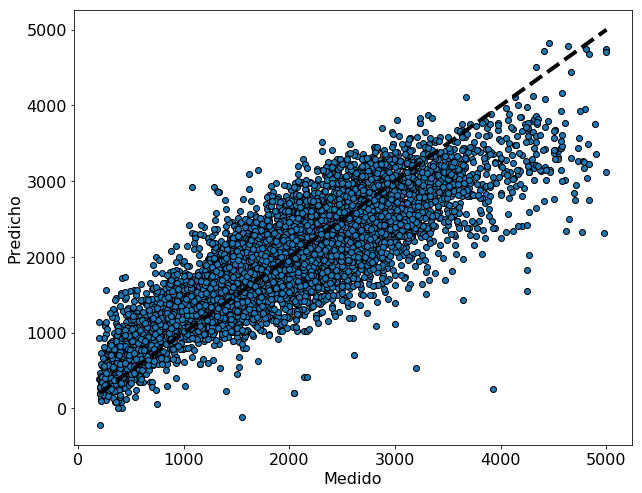

In [145]:
scatter(y_test, predictions2, y)

### 8) Vamos a crear una Feature que es el cuadrado de la feature "surface_total_in_m2"

#### veremos si mejora la respuesta del modelo

#### Armamo "X3_cuad"

In [81]:
X3.shape

(35739, 1287)

In [82]:
X3.columns

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera',
       ...
       '988/397', '989/396', '989/401', '990/397', '990/400', '990/408', '991/410', '993/398', '994/397', '994/419'], dtype='object', length=1287)

In [83]:
sup_x_sup = X3.surface_total_in_m2 * X3.surface_total_in_m2
sup_x_sup.name

'surface_total_in_m2'

In [84]:
sup_x_sup.rename("sup_x_sup", axis=1, inplace=True)
sup_x_sup.name

'sup_x_sup'

In [85]:
X3_cuad = pd.concat([X3, sup_x_sup],axis=1)
X3_cuad.shape

(35739, 1288)

In [86]:
X3_cuad.columns

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera',
       ...
       '989/396', '989/401', '990/397', '990/400', '990/408', '991/410', '993/398', '994/397', '994/419', 'sup_x_sup'], dtype='object', length=1288)

#### Probamos los diferentes modelos incluyendo nuestra nueva feature ("sup_x_sup"):
### "X3_cuad"

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X3_cuad, y)

#### 8-a) Ridge Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [146]:
rlm = linear_model.Ridge(alpha=0.01, normalize=True)   # EN GENERAL SIEMPRESE SE HACE NORMALIZACIÓN CON RIDGE

ridge_model = rlm.fit(X_train, y_train)
predictions = ridge_model.predict(X_train)
predictions2 = ridge_model.predict(X_test)

print ("r^2 Train:", ridge_model.score(X_train, y_train))
print ("r^2 TEST:", ridge_model.score(X_test, y_test))

r^2 Train: 0.7168774202536436
r^2 TEST: 0.7081548686679935


In [89]:
ridge_model.alpha

0.01

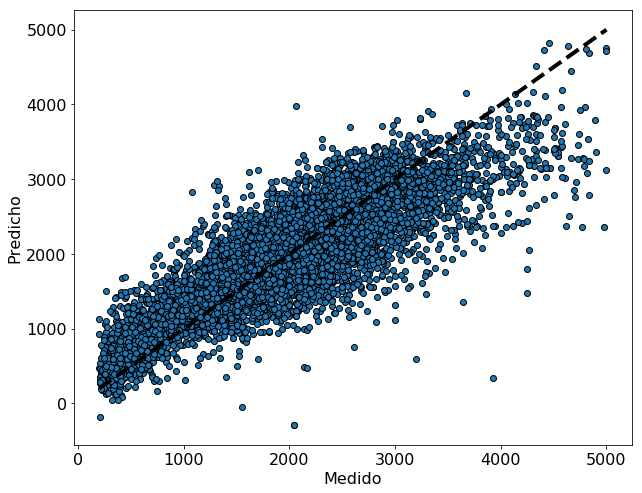

In [147]:
scatter(y_test, predictions2, y)

#### 8-b) Lasso Regression

##### probamos varios Alpha manualmente, y dejamos el más bajo pero sin seguir diminuyéndolo luego de que no se obervan mejoras en R2

In [148]:
lasso = linear_model.Lasso(alpha=0.01, normalize=True) # SIEMPRE HACER NORMALIZACIÓN CON LASSO

lasso_model = lasso.fit(X_train, y_train)
predictions = lasso_model.predict(X_train)
predictions2 = lasso_model.predict(X_test)

print ("r^2 Train:", lasso_model.score(X_train, y_train))
print ("r^2 TEST:", lasso_model.score(X_test, y_test))

r^2 Train: 0.7156378473137128
r^2 TEST: 0.7075430103224694


In [91]:
lasso_model.alpha

0.01

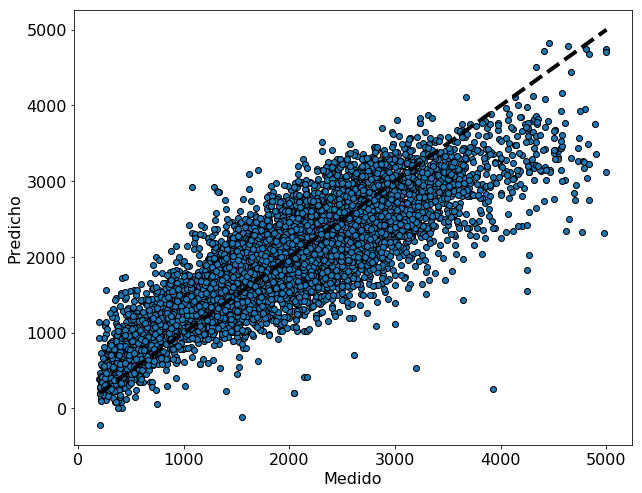

In [149]:
scatter(y_test, predictions2, y)

#### Para ambos modelos no hemos notado una variación significativa



#### Vamos a verificarlos utilizando CORSS-VALIDATION

CROSS-VALIDATION Y REGULTARIZACIÓN:

#### Importamos algunas librerías más requeridas para este punto

In [92]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold

from sklearn.preprocessing import StandardScaler

# KFold: Provides train/test indices to split data in train/test sets. 
# Split dataset into k consecutive folds (without shuffling by default).
# OBJETO PARA CROSS-VALIDATION (K-Folds cross-validator) 
cv = KFold(3, shuffle=True)
# LO BUENO DE USAR ESTE OBJETO, ES QUE PODRÍA USARLO PARA HACER SIEMPRE LAS MISMAS PARTICIONES

#### 8-c) Ridge Regression CV (Cross Validation)

In [93]:
# INSTANCIO Y FITEO EL MODELO RIDGE  -- ACÁ PRUEBO NORMALIZANDO
model = linear_model.RidgeCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean()))

{'alpha': 0.01, 'scores': array([0.70531344, 0.71200449, 0.70975428]), 'mean_score': 0.709024067293092}


In [94]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7127479318792607

#### 8-d) Lasso Regression CV (Cross Validation)

In [95]:
# INSTANCIO Y FITEO EL MODELO LASSO  -- ACÁ PRUEBO SIN NORMALIZAR

model = linear_model.LassoCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.71339934, 0.70531053, 0.71155848]), 'mean_score': 0.7100894509290067, 'zero_coefs': 979}


In [96]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7129272852171924

#### Se verificó para diferentes particiones los R2 Test y Train

### 9) Creación de Features Relacionales

#### Vamos a crear Features relacionando las columnas Dummie de las Parcelas con la columnas "surface_total_in_m2"

#### veremos si mejora la respuesta del modelo

#### Armamos "X3_cuad_relac"

In [97]:
X3_cuad.shape

(35739, 1288)

In [98]:
X3_cuad.columns[0:20]

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera', 'piscina_house', 'piscina_depart', 'tipo_propiedad_store', '1064/740', '1066/1311', '1069/693', '1070/683', '1118/1634', '1126/1626', '1126/1645'], dtype='object')

In [99]:
X3_cuad.columns[-1]

'sup_x_sup'

#### En base a las dos celdas anteriores SELECCIONAR A MANO LAS QUE NO VOY A MULTIPLICAR (las que no son dummies de posición y que hayan quedado luego de las sucesivas eliminaciones de fueatures con Pvalue > 0,01)

In [100]:
relac = X3_cuad.drop(['surface_total_in_m2', 'surface_covered_in_m2', 'garage', 'lavadero', 'balcon', 'patio', 'amenities', 'estrenar', 'gimnasio', 'baulera', 'piscina_house', 'piscina_depart', 'sup_x_sup'],
                     axis=1)

In [101]:
relac.shape

(35739, 1275)

In [102]:
X3_cuad.surface_total_in_m2.shape

(35739,)

In [103]:
relaciones = relac.mul(X3_cuad.surface_total_in_m2, axis=0)
relaciones.shape

(35739, 1275)

In [104]:
relaciones[relaciones.columns[0]]

0         0.0
2         0.0
7         0.0
8         0.0
12        0.0
         ... 
118454    0.0
118464    0.0
118471    0.0
118482    0.0
118503    0.0
Name: tipo_propiedad_store, Length: 35739, dtype: float64

In [105]:
relaciones[relaciones.columns[0]].loc[(relaciones[relaciones.columns[0]])>0]

94        180.0
1598      300.0
5330      462.0
7022       20.0
7303      381.0
7510       97.0
8035      228.0
8657       60.0
8695      228.0
8875       88.0
9215       54.0
11578     500.0
12424     154.0
13293     154.0
18613     380.0
19384     305.0
20204     260.0
20213     275.0
21113      58.0
26027     370.0
30002      31.0
30445     500.0
30762     501.0
31933      86.0
33287     250.0
35339     375.0
36395     174.0
36396     195.0
36397     191.0
36398     198.0
36678     180.0
37084     220.0
38324      49.0
39476     227.0
41116     280.0
41499     220.0
43971      31.0
45860     175.0
46226     425.0
46486      40.0
50656      20.0
51239      64.0
51513     520.0
53393      30.0
55114     180.0
57741     381.0
58026     220.0
59039     407.0
59152      78.0
60121     174.0
60122     195.0
60123     191.0
60124     198.0
62249      45.0
62529      52.0
62531     300.0
67189     167.0
70512     330.0
72132     329.0
74484     176.0
75567      35.0
75904      90.0
78417   

In [106]:
# PEQUEÑA VERIFICACIÓN
display(X3_cuad.surface_total_in_m2[(relaciones[relaciones.columns[0]])>0])
print("")
display(relaciones[relaciones.columns[0]].loc[(relaciones[relaciones.columns[0]])>0])  # miro cóm queda

94        180.0
1598      300.0
5330      462.0
7022       20.0
7303      381.0
7510       97.0
8035      228.0
8657       60.0
8695      228.0
8875       88.0
9215       54.0
11578     500.0
12424     154.0
13293     154.0
18613     380.0
19384     305.0
20204     260.0
20213     275.0
21113      58.0
26027     370.0
30002      31.0
30445     500.0
30762     501.0
31933      86.0
33287     250.0
35339     375.0
36395     174.0
36396     195.0
36397     191.0
36398     198.0
36678     180.0
37084     220.0
38324      49.0
39476     227.0
41116     280.0
41499     220.0
43971      31.0
45860     175.0
46226     425.0
46486      40.0
50656      20.0
51239      64.0
51513     520.0
53393      30.0
55114     180.0
57741     381.0
58026     220.0
59039     407.0
59152      78.0
60121     174.0
60122     195.0
60123     191.0
60124     198.0
62249      45.0
62529      52.0
62531     300.0
67189     167.0
70512     330.0
72132     329.0
74484     176.0
75567      35.0
75904      90.0
78417   

94        180.0
1598      300.0
5330      462.0
7022       20.0
7303      381.0
7510       97.0
8035      228.0
8657       60.0
8695      228.0
8875       88.0
9215       54.0
11578     500.0
12424     154.0
13293     154.0
18613     380.0
19384     305.0
20204     260.0
20213     275.0
21113      58.0
26027     370.0
30002      31.0
30445     500.0
30762     501.0
31933      86.0
33287     250.0
35339     375.0
36395     174.0
36396     195.0
36397     191.0
36398     198.0
36678     180.0
37084     220.0
38324      49.0
39476     227.0
41116     280.0
41499     220.0
43971      31.0
45860     175.0
46226     425.0
46486      40.0
50656      20.0
51239      64.0
51513     520.0
53393      30.0
55114     180.0
57741     381.0
58026     220.0
59039     407.0
59152      78.0
60121     174.0
60122     195.0
60123     191.0
60124     198.0
62249      45.0
62529      52.0
62531     300.0
67189     167.0
70512     330.0
72132     329.0
74484     176.0
75567      35.0
75904      90.0
78417   

In [107]:
columnas = list(range(relaciones.columns.size))
columnas[-1]

1274

In [108]:
relaciones.set_axis(columnas, axis=1, inplace=True)   # renombro las columnas nuevas (las relacionales)

In [109]:
relaciones.columns

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274], dtype='int64', length=1275)

In [110]:
relaciones.shape

(35739, 1275)

In [111]:
X3_cuad_relac = pd.concat([X3_cuad, relaciones],axis=1)
X3_cuad_relac.shape

(35739, 2563)

In [112]:
X3_cuad_relac.columns

Index([  'surface_total_in_m2', 'surface_covered_in_m2',                'garage',              'lavadero',                'balcon',                 'patio',             'amenities',              'estrenar',              'gimnasio',               'baulera',
       ...
                          1265,                    1266,                    1267,                    1268,                    1269,                    1270,                    1271,                    1272,                    1273,                    1274], dtype='object', length=2563)

#### Probamos los diferentes modelos incluyendo nuestras nuevas features RELACIONALES:
### "X3_cuad_relac"

#### Vamos a verificarlos utilizando CORSS-VALIDATION

CROSS-VALIDATION Y REGULTARIZACIÓN:

#### con "X3_cuad_relac"

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X3_cuad_relac, y)

#### 9-a) Ridge Regression CV (Cross Validation)

In [114]:
# INSTANCIO Y FITEO EL MODELO RIDGE  -- ACÁ PRUEBO NORMALIZANDO
model = linear_model.RidgeCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean()))


{'alpha': 0.01, 'scores': array([0.71365283, 0.68410683, 0.69884931]), 'mean_score': 0.698869654250303}


In [115]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7101106754039704

#### 9-b) Lasso Regression CV (Cross Validation)

In [116]:
# INSTANCIO Y FITEO EL MODELO LASSO  -- ACÁ PRUEBO SIN NORMALIZAR

model = linear_model.LassoCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.70197456, 0.70655504, 0.71393867]), 'mean_score': 0.7074894239827377, 'zero_coefs': 2101}


In [117]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7104477009240475

#### 9-c) Stats Model Linear

#### Armamos "X3_cuad_relac_const"

In [118]:
# USANDO statsmodel
# Tenemos que agregar explícitamente a una constante:
X3_cuad_relac_const = sm.add_constant(X3_cuad_relac)
X3_cuad_relac_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,garage,lavadero,balcon,patio,amenities,estrenar,gimnasio,...,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274
0,1.0,55.0,40.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,55.0,55.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,45.0,40.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
X3_cuad_relac_const = X3_cuad_relac_const.astype("int", copy=True)   # lo paso a int sino no me da la memoria

In [120]:
# USANDO statsmodel
X_train, X_test, y_train, y_test = train_test_split(X3_cuad_relac_const, y)
model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print("EMC train:", mean_squared_error(y_train, predictions))
print("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: test:", r2_score(y_test, predictions2))  # PREDICT


EMC train: 185704.76664149732
EMC train: 207217.40929892412
R2:  0.7344636743958035
R2: train: 0.7344636743958035
R2: test: 0.7026754083716718


##### SE OBSERVA QUE BAJÓ EL R2 TEST

In [121]:
print (model.summary())

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\envs\dhdsblendv2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     125.1
Date:                Tue, 23 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:51:28   Log-Likelihood:            -2.0063e+05
No. Observations:               26804   AIC:                         4.024e+05
Df Residuals:                   26223   BIC:                         4.072e+05
Df Model:                         580                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1664.70

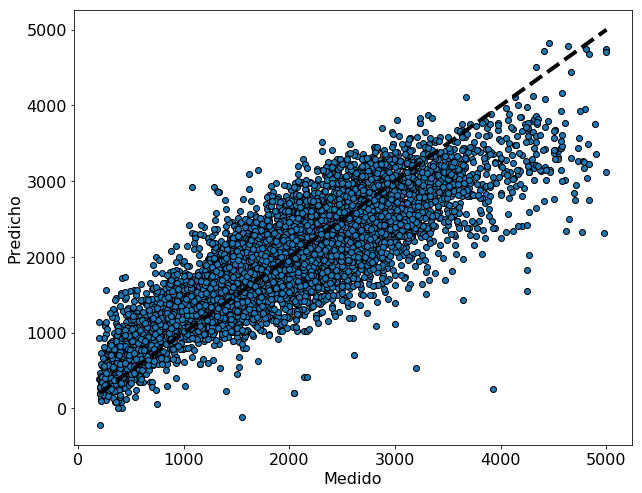

In [150]:
scatter(y_test, predictions2, y)

#### Tercer eliminación de features con STATS MODEL - OLS:
##### Se eliminaran Features cuyo Pvalue supere el 1% (es decir que no están afectando a la varianza ni al sesgo del modelo)

In [122]:
not_feature_cols = model.pvalues[model.pvalues>0.01].index.values
not_feature_cols

array(['lavadero', 'tipo_propiedad_store', '1064/740', '1066/1311',
       '1070/683', '1126/1626', '1126/1645', '1131/1652', '1136/1631',
       '1179/1699', '1180/1507', '1189/1711', '1189/1712', '1191/1714',
       '1195/1716', '1195/1717', '1195/1718', '1220/1731', '1221/1731',
       '1227/1730', '1325/1607', '1339/1575', '1341/1614', '1342/1605',
       '1344/1564', '1347/1594', '1347/1596', '1347/1597', '1348/1594',
       '1348/1596', '1350/1596', '1352/1575', '1355/1575', '1355/1585',
       '1356/1566', '1356/1584', '1357/1559', '1358/1537', '1358/1558',
       '1359/1557', '1359/1568', '1359/1572', '1360/1497', '1362/1557',
       '1363/1546', '1363/1547', '1363/1560', '1365/1532', '1365/1558',
       '1366/1532', '1366/1558', '1367/1543', '1367/1564', '1369/1542',
       '1369/1559', '1369/1561', '1370/1549', '1370/1560', '1370/1561',
       '1370/1563', '1370/1564', '1372/1523', '1372/1534', '1373/1557',
       '1374/1536', '1374/1550', '1374/1556', '1375/1549', '1375/1554

#### Armamos "X4_cuad_relac_const"

In [123]:
X4_cuad_relac_const = X3_cuad_relac_const.drop(not_feature_cols, axis=1)

In [124]:
X4_cuad_relac_const.head(3)

,const,surface_total_in_m2,surface_covered_in_m2,garage,balcon,patio,amenities,estrenar,gimnasio,baulera,...,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274
0,1,55,40,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,55,55,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,45,40,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### STATS MODEL con "X4_cuad_relac_const"

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X4_cuad_relac_const, y)

In [126]:
# USANDO statsmodel

model = sm.OLS(y_train, X_train).fit()

predictions = model.predict(X_train)
predictions2 = model.predict(X_test)

# Imprimimos el MSE y un resumen del modelo
print ("EMC train:", mean_squared_error(y_train, predictions))
print ("EMC train:", mean_squared_error(y_test, predictions2))

print('R2: ', model.rsquared) # model
print("R2: train:", r2_score(y_train, predictions))  # TRAIN
print("R2: test:", r2_score(y_test, predictions2))  # PREDICT

EMC train: 194037.78377727463
EMC train: 208719.53628350102
R2:  0.7218555104857636
R2: train: 0.7218555104857636
R2: test: 0.7028094633717853


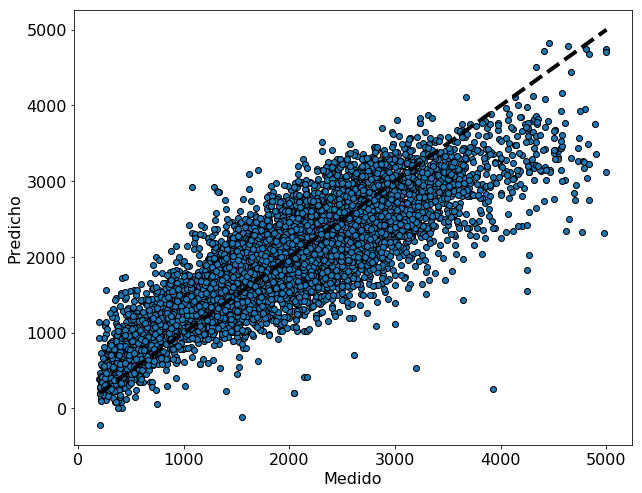

In [151]:
scatter(y_test, predictions2, y)

#### También probemos RIDGE_CV y LASSO_CV CON con "X4_cuad_relac"

#### armammos "X4_cuad_relac"

In [127]:
X4_cuad_relac = X4_cuad_relac_const.drop(["const"], axis=1)

In [128]:
X4_cuad_relac.head(3)

,surface_total_in_m2,surface_covered_in_m2,garage,balcon,patio,amenities,estrenar,gimnasio,baulera,piscina_house,...,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274
0,55,40,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,45,40,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### probamos con "X4_cuad_relac"

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X4_cuad_relac, y)

#### 9-d) Lasso Regression CV (Cross Validation)

In [130]:
# INSTANCIO Y FITEO EL MODELO LASSO  -- ACÁ PRUEBO SIN NORMALIZAR

model = linear_model.LassoCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.7066662 , 0.69796594, 0.7057771 ]), 'mean_score': 0.7034697499958104, 'zero_coefs': 1651}


In [131]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.7075430103224694

#### 9-e) Ridge Regression CV (Cross Validation)

##### Ridge CV (Cross Validation)

In [132]:
# INSTANCIO Y FITEO EL MODELO RIDGE  -- ACÁ PRUEBO NORMALIZANDO
model = linear_model.RidgeCV(alphas=np.linspace(0.01, 0.1, 10), normalize=True).fit(X_train, y_train)

# HAGO CROSS VALIDATIONS
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# MUESTRA TODOS LOS PARÁMETROS OBTENIDOS
print(dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean()))
# se muestra que eliminó ("descartó") cierta cantidad de coeficientes


{'alpha': 0.01, 'scores': array([0.69895723, 0.71286231, 0.69889902]), 'mean_score': 0.7035728564415393}


In [133]:
#r2 TEST:
model.score(X_test, y_test)  # acá vemos con los datos de TEST

0.708154868667987

<hr id="ToCSV">
<h2 style="color: lightblue">CONCLUSIONES</h2>